In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [5]:
#Read
df = pd.read_csv('data/movie_new.tsv', delimiter='\t', encoding='ISO-8859-1')


In [6]:
indexes = df[ df['genre'].str.find('Adult') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('News') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Talk-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Game-Show') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Short') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Reality-TV') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Film-Noir') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Sport') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Musical') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Music') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Documentary') != -1 ].index
df.drop(indexes, inplace=True)
indexes = df[ df['genre'].str.find('Biography') != -1 ].index
df.drop(indexes, inplace=True)


df['genre'] = df['genre'].str.replace('History', 'War')
df['genre'] = df['genre'].str.replace('War', 'Action')
df['genre'] = df['genre'].str.replace('Sci-Fi', 'Fantasy')
df['genre'] = df['genre'].str.replace('Western', 'Action')
df['genre'] = df['genre'].str.replace('Crime', 'Drama')
df['genre'] = df['genre'].str.replace('Mystery', 'Thriller')
df['genre'] = df['genre'].str.replace('Adventure', 'Action')


In [7]:
ser = pd.Series(df['genre'].str.split(','))
for index, lis in enumerate(ser):
    ser.iat[index] = pd.unique(lis)[:2]

In [8]:
df['genre'] = ser

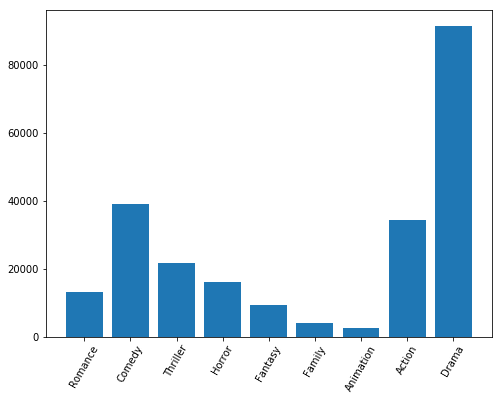

In [10]:
#Majority of movies are comedy, documentary or drama apparently.

fig = plt.figure(figsize=(8,6))
genreC = {}
for genres in df.genre:
    for genre in genres:
        try:
            genreC[genre] = genreC[genre] + 1
        except KeyError:
            genreC[genre] = 0
plt.bar(genreC.keys(), genreC.values())
plt.xticks(rotation=60)
plt.show()

In [101]:
from sklearn.svm import LinearSVC
from sklearn_porter import Porter

tfidf = TfidfVectorizer(lowercase = True, sublinear_tf=True, norm='l2', ngram_range=(1, 2), strip_accents='unicode')
features = tfidf.fit_transform(df.movie)
x_train, x_val, y_train, y_val, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.30, random_state=5000)
#unweighted:
svc = LinearSVC()
labels = df.genre_id
svc.fit(x_train, y_train)
print("unweighted:")
print(svc.score(x_val, y_val))

#weighted:
svc_w = LinearSVC(class_weight='balanced')
print("weighted")
svc_w.fit(x_train, y_train)
print(svc_w.score(x_val, y_val))

AttributeError: 'DataFrame' object has no attribute 'genre_id'

In [53]:
from sklearn.externals import joblib
joblib.dump(svc_w, 'model.pkl')

['model.pkl']

In [12]:
def getsvcprediction(model, title):
    return {title : id_to_category[model.predict(tfidf.transform([title]))[0]]}

In [13]:
#print(x_train)
print(getsvcprediction(svc, "Crocodile Dundee"))
print(getsvcprediction(svc, "Bee Movie"))
print(getsvcprediction(svc, "Toy Story"))
print(getsvcprediction(svc, "Zombies Return"))
print(getsvcprediction(svc, "Blade Runner"))
print(getsvcprediction(svc, "The Tower"))
print(getsvcprediction(svc, "Berlins Brewery"))
print(getsvcprediction(svc, "Bubble Kid"))
print(getsvcprediction(svc, "Overlord"))

print()
print(getsvcprediction(svc_w, "Crocodile Dundee"))
print(getsvcprediction(svc_w, "Bee Movie"))
print(getsvcprediction(svc_w, "Toy Story"))
print(getsvcprediction(svc_w, "Zombies Return"))
print(getsvcprediction(svc_w, "Blade Runner"))
print(getsvcprediction(svc_w, "The Tower"))
print(getsvcprediction(svc_w, "Berlins Brewery"))
print(getsvcprediction(svc_w, "Bubble Kid"))
print(getsvcprediction(svc_w, "Overlord"))


{'Crocodile Dundee': 'Comedy'}
{'Bee Movie': 'Adventure'}
{'Toy Story': 'Family'}
{'Zombies Return': 'Horror'}
{'Blade Runner': 'Sci-Fi'}
{'The Tower': 'Drama'}
{'Berlins Brewery': 'Music'}
{'Bubble Kid': 'Animation'}
{'Overlord': 'Drama'}

{'Crocodile Dundee': 'Comedy'}
{'Bee Movie': 'Adventure'}
{'Toy Story': 'Family'}
{'Zombies Return': 'Horror'}
{'Blade Runner': 'Sci-Fi'}
{'The Tower': 'Sci-Fi'}
{'Berlins Brewery': 'Music'}
{'Bubble Kid': 'Animation'}
{'Overlord': 'Drama'}


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D


mlb = MultiLabelBinarizer()
mlb.fit(df.genre)
labels = mlb.classes_

filter_length = 300
max_words = 13000
maxlen = 10

num_classes = len(genreC)
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.movie)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))
    
def baseline():
    model = Sequential()
    model.add(Dense(num_classes, input_dim=maxlen, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [12]:
from sklearn.model_selection import train_test_split

x = get_features(df.movie)
y = mlb.transform(df.genre)
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(165439, 10)
(165439, 9)


In [21]:
countGenres = 0
for genres in df.genre:
    countGenres = countGenres + len(genres)

class_weights = {}
for index, label in enumerate(labels):
    class_weights[index] = countGenres/genreC[label]
    print(label + " " + str(countGenres/genreC[label]))


Action 6.735493244224902
Animation 93.01845906902086
Comedy 5.926772519240111
Drama 2.5341306629351057
Family 57.936015996001
Fantasy 25.20134811915634
Horror 14.428109050168057
Romance 17.494490566037737
Thriller 10.638975582889664


In [48]:
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model-baseline-w.h5', save_best_only=True)
]

model = baseline()


history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

baseline_model = keras.models.load_model('model-baseline-w.h5')
metrics = baseline_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))


callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=5),
    ModelCheckpoint(filepath='model-baseline-uw.h5', save_best_only=True)
]

model = baseline()

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

baseline_model = keras.models.load_model('model-baseline-uw.h5')
metrics = baseline_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

Train on 119115 samples, validate on 13236 samples
Epoch 1/20
119115/119115 [==============================] - 55s 461us/step - loss: 21.7384 - categorical_accuracy: 0.2987 - val_loss: 17.5889 - val_categorical_accuracy: 0.2396
Epoch 2/20
119115/119115 [==============================] - 54s 453us/step - loss: 15.6647 - categorical_accuracy: 0.2772 - val_loss: 13.7686 - val_categorical_accuracy: 0.2659
Epoch 3/20
119115/119115 [==============================] - 56s 471us/step - loss: 12.7852 - categorical_accuracy: 0.2493 - val_loss: 11.1457 - val_categorical_accuracy: 0.1544
Epoch 4/20
119115/119115 [==============================] - 54s 454us/step - loss: 9.9519 - categorical_accuracy: 0.2308 - val_loss: 7.4521 - val_categorical_accuracy: 0.2765
Epoch 5/20
119115/119115 [==============================] - 48s 404us/step - loss: 6.6544 - categorical_accuracy: 0.2544 - val_loss: 5.3521 - val_categorical_accuracy: 0.3396
Epoch 6/20
119115/119115 [==============================] - 56s 471u

KeyboardInterrupt: 

NameError: name 'plot_history' is not defined

In [12]:
model = classify_movies_conv1d()
history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Train on 147285 samples, validate on 16366 samples
Epoch 1/20
147285/147285 [==============================] - 290s 2ms/step - loss: 3.1824 - categorical_accuracy: 0.3292 - val_loss: 3.0363 - val_categorical_accuracy: 0.3490
Epoch 2/20
147285/147285 [==============================] - 277s 2ms/step - loss: 2.9860 - categorical_accuracy: 0.3594 - val_loss: 2.9847 - val_categorical_accuracy: 0.3606
Epoch 3/20
147285/147285 [==============================] - 276s 2ms/step - loss: 2.8948 - categorical_accuracy: 0.3674 - val_loss: 3.0213 - val_categorical_accuracy: 0.3250
Epoch 4/20
147285/147285 [==============================] - 276s 2ms/step - loss: 2.8364 - categorical_accuracy: 0.3696 - val_loss: 3.0504 - val_categorical_accuracy: 0.3058
Epoch 5/20
147285/147285 [==============================] - 276s 2ms/step - loss: 2.7912 - categorical_accuracy: 0.3705 - val_loss: 3.0468 - val_categorical_accuracy: 0.3100
Epoch 6/20
147285/147285 [==============================] - 275s 2ms/step - los

NameError: name 'cnn_model' is not defined

40913/40913 [==============================] - 18s 428us/step
loss: 0.338522674168336
categorical_accuracy: 0.3695402439326107


In [43]:
conv1d = keras.models.load_model('model-conv1d_weighted.h5')
f = get_features([""])
p1 = prediction_to_label(conv1d.predict(f)[0])
df_t = pd.DataFrame()
df_t['label'] = p1.keys()
df_t['p'] = p1.values()
df_t.sort_values(by='p', ascending=False)

ValueError: Error when checking input: expected embedding_1_input to have shape (2000,) but got array with shape (200,)

In [30]:
def classify_movies_conv1d(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    # create model
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(9, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [33]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 25
embedding_dim = 50
maxlen = 10
output_file = 'data/output.txt'

sentences = df['movie'].values
y = mlb.transform(df['genre'])
sentences_train, sentences_test, y_train, y_val = train_test_split(sentences, y, test_size=0.2, random_state=2500)

tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(sentences_train)
x_train = tokenizer.texts_to_sequences(sentences_train)
x_val = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

param_grid = dict(num_filters=[16, 32, 64],
                  kernel_size=[2, 3, 4],
                  vocab_size=[vocab_size], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=classify_movies_conv1d,
                        epochs=epochs, batch_size=20, 
                        verbose=True)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=5, verbose=1, n_iter=5, n_jobs=-1)

grid_result = grid.fit(x_train, y_train, class_weight=class_weights)
test_accuracy = grid.score(x_val, y_val)

with open(output_file, 'a') as f:
    s = ('Best Accuracy : ''{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(grid_result.best_score_, grid_result.best_params_, test_accuracy)
    print(output_string)
    f.write(output_string)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x1dc7a2dcba8 state=finished raised BrokenProcessPool>
sklearn.externals.joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "C:\Users\Matt\Anaconda3\envs\workspace-gpu\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py", line 393, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\Matt\Anaconda3\envs\workspace-gpu\lib\multiprocessing\queues.py", line 113, in get
    return ForkingPickler.loads(res)
AttributeError: Can't get attribute 'classify_movies_conv1d' on <module '__main__' (built-in)>
'''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Matt\Anaconda3\envs\workspace-gpu\lib\site-packages\sklearn\externals\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.